<a href="https://colab.research.google.com/github/peeyushsinghal/EVA/blob/main/%20S6-AssignmentSolution%20/EVA_S6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Importing Libraries

In [8]:
# import torch
import torch
from torchvision import datasets,transforms
%matplotlib inline
import matplotlib.pyplot as plt # for visualizing images
import random # for random image index
import torch.nn as nn # for network
import torch.nn.functional as F # for forward method
import torch.optim as optim # for optimizer
!pip install torchsummary
from torchsummary import summary # for model summary and params
from tqdm import tqdm # for beautiful model training updates

Seed and Cuda

In [3]:
# check for cuda
cuda = torch.cuda.is_available()
print (f' Cuda Status : {cuda}')

# setting seed
SEED = 42 # arbit seed, why 42 - because in hitch hikers guide to galaxy it is answer to everything
# torch.cuda.seed(SEED) 
torch.cuda.manual_seed_all(SEED) if cuda else torch.manual_seed(SEED)

 Cuda Status : True


### Downloading dataset, splitting datasets
loading dataset

In [4]:
train = datasets.MNIST(
    root = './',# directory where data needs to be stored
    train = True, # get the training portion of the dataset
    download = True, # downloads
    transform = transforms.Compose([
                  transforms.RandomRotation((-7.0, 7.0), fill=(1,)), #random rotation
                  transforms.ToTensor(),# converts to tesnor
                  transforms.Normalize((0.1307,), (0.3081,))# Normalize
                ])
    )

test = datasets.MNIST(
    root = './',# directory where data needs to be stored
    train = False, # get the test portion of the dataset
    download = True, # downloads
    transform = transforms.Compose([
                  transforms.ToTensor(),# converts to tesnor
                  transforms.Normalize((0.1307,), (0.3081,))# Normalize
                ])
    )

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Train and Test Dataloader

In [5]:
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory = True) if cuda else dict(shuffle=True, batch_size=64)

train_loader = torch.utils.data.DataLoader(
    dataset=train,# train dataset
    **dataloader_args # the dataloader arguments change dependent on cuda is available or not
    )

test_loader = torch.utils.data.DataLoader(
    dataset = test,# test dataset 
    **dataloader_args # the dataloader arguments change dependent on cuda is available or not
)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Checking Dataloaders
- sample data

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([128, 1, 28, 28])
torch.Size([128])


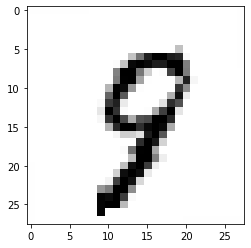

In [6]:
images, labels  = next(iter(train_loader))
print(images.shape)
print(labels.shape)
# printing random image and seeing
plt.imshow(images[random.randint(0,len(images))].numpy().squeeze(), cmap='gray_r')

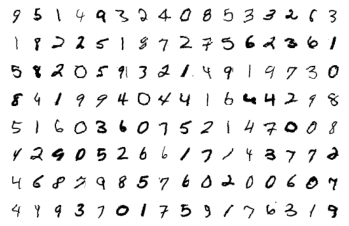

In [7]:
# Looking at more images
figure = plt.figure()
for index in range(1, len(images) + 1): # assumption: batch size would be atleast 8
    plt.subplot(8, int(len(images)/8), index)
    plt.axis('off')
    plt.imshow(images[index-1].numpy().squeeze(), cmap='gray_r')

### Network

In [9]:
import torch.nn as nn # for network


In [11]:
drop_out_value = 0.1

class Network(nn.Module):
  def __init__(self, mode = None):
    super(Network,self).__init__() # extending super class method
    self.mode = mode
    print ("mode :", mode)

    # Input Block
    self.convblock1 = nn.Sequential(
        nn.Conv2d(1,12,3), # In- 1x28x28, Out- 12x26x26, RF- 3x3, Jump_in -1, Jump_out -1
        nn.ReLU()
        # ,
        # nn.BatchNorm2d(12),
        # nn.Dropout(drop_out_value)
    ) 

    if mode =="BN":
      self.norm1 = nn.BatchNorm2d(12) # BatchNorm
    if mode == "LN":
      self.norm1 = nn.LayerNorm([12,26,26]) # Layer Norm
    if mode == "GN":
      self.norm1 = nn.GroupNorm(2,12) # Group Norm

    self.dropout1 = nn.Dropout(drop_out_value) # drop out
    ###---------------------------------------------------

    # Conv Block 2
    self.convblock2 = nn.Sequential(
        nn.Conv2d(12,12,3), # In- 12x26x26, Out- 12x24x24, RF- 5x5, Jump_in -1, Jump_out -1
        nn.ReLU()
        # ,
        # nn.BatchNorm2d(12),
        # nn.Dropout(drop_out_value)
    ) 

    if mode =="BN":
      self.norm2 = nn.BatchNorm2d(12) # BatchNorm
    if mode == "LN":
      self.norm2 = nn.LayerNorm([12,24,24]) # Layer Norm
    if mode == "GN":
      self.norm2 = nn.GroupNorm(2,12) # Group Norm

    self.dropout2 = nn.Dropout(drop_out_value) # drop out
    ###---------------------------------------------------


    # Conv Block 3
    self.convblock3 = nn.Sequential(
        nn.Conv2d(12,12,3), # In- 12x24x24, Out- 12x22x22, RF- 7x7, Jump_in -1, Jump_out -1
        nn.ReLU()
        # ,
        # nn.BatchNorm2d(12),
        # nn.Dropout(drop_out_value)
    ) 

    if mode =="BN":
      self.norm3 = nn.BatchNorm2d(12) # BatchNorm
    if mode == "LN":
      self.norm3 = nn.LayerNorm([12,22,22]) # Layer Norm
    if mode == "GN":
      self.norm3 = nn.GroupNorm(2,12) # Group Norm

    self.dropout3 = nn.Dropout(drop_out_value) # drop out
    ###---------------------------------------------------

    self.convblock3_1 = nn.Sequential(
        nn.Conv2d(12,12,3), # In- 12x22x22, Out- 12x20x20, RF- 7x7, Jump_in -1, Jump_out -1
        nn.ReLU()
        # ,
        # nn.BatchNorm2d(12),
        # nn.Dropout(drop_out_value)
    ) 

    if mode =="BN":
      self.norm3_1 = nn.BatchNorm2d(12) # BatchNorm
    if mode == "LN":
      self.norm3_1 = nn.LayerNorm([12,20,20]) # Layer Norm
    if mode == "GN":
      self.norm3_1 = nn.GroupNorm(2,12) # Group Norm

    self.dropout3_1 = nn.Dropout(drop_out_value) # drop out
    ###---------------------------------------------------

    self.convblock3_2 = nn.Sequential(
        nn.Conv2d(12,12,3), # In- 12x20x20, Out- 12x18x18, RF- 7x7, Jump_in -1, Jump_out -1
        nn.ReLU()
        # ,
        # nn.BatchNorm2d(12),
        # nn.Dropout(drop_out_value)
    )

    if mode =="BN":
      self.norm3_2 = nn.BatchNorm2d(12) # BatchNorm
    if mode == "LN":
      self.norm3_2 = nn.LayerNorm([12,18,18]) # Layer Norm
    if mode == "GN":
      self.norm3_2 = nn.GroupNorm(2,12) # Group Norm

    self.dropout3_2 = nn.Dropout(drop_out_value) # drop out
    ###---------------------------------------------------
    

    #### Transition Block 1 
    self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # In- 12x18x18 Out- 12x9x9 RF- 8x8, Jump_in -1, Jump_out -2


    # Conv Block 5
    self.convblock5 = nn.Sequential(
        nn.Conv2d(12,16,3), # In- 12x9x9 Out- 16x7x7 RF- 12x12, Jump_in -2, Jump_out -2
        nn.ReLU()
        # ,
        # nn.BatchNorm2d(16),
        # nn.Dropout(drop_out_value)
    ) 

    if mode =="BN":
      self.norm5 = nn.BatchNorm2d(16) # BatchNorm
    if mode == "LN":
      self.norm5 = nn.LayerNorm([16,7,7]) # Layer Norm
    if mode == "GN":
      self.norm5 = nn.GroupNorm(2,16) # Group Norm

    self.dropout5 = nn.Dropout(drop_out_value) # drop out
    ###---------------------------------------------------

    # Conv Block 6
    self.convblock6 = nn.Sequential(
        nn.Conv2d(16,16,3), # In- 16x7x7 Out- 16x5x5 RF- 16x16, Jump_in -2, Jump_out -2
        nn.ReLU()
        # ,
        # nn.BatchNorm2d(16),
        # nn.Dropout(drop_out_value)
    ) 

    if mode =="BN":
      self.norm6 = nn.BatchNorm2d(16) # BatchNorm
    if mode == "LN":
      self.norm6 = nn.LayerNorm([16,5,5]) # Layer Norm
    if mode == "GN":
      self.norm6 = nn.GroupNorm(2,16) # Group Norm

    self.dropout6 = nn.Dropout(drop_out_value) # drop out
    ###---------------------------------------------------

    # Output Block
    self.convblock7 = nn.Sequential(
        nn.Conv2d(16,10,1), # In- 16x5x5 Out- 10x5x5, RF- 16x16, Jump_in -2, Jump_out -2
        nn.ReLU()
        # ,
        # nn.BatchNorm2d(10),
        # nn.Dropout(drop_out_value)
    ) 

    if mode =="BN":
      self.norm7 = nn.BatchNorm2d(10) # BatchNorm
    if mode == "LN":
      self.norm7 = nn.LayerNorm([10,5,5]) # Layer Norm
    if mode == "GN":
      self.norm7 = nn.GroupNorm(2,10) # Group Norm

    self.dropout7 = nn.Dropout(drop_out_value) # drop out
    ###---------------------------------------------------

    self.gap = nn.AvgPool2d(5) # In- 10x5x5, Out- 10x1x1, RF- 16x16, Jump_in -2, Jump_out -2

  
  def forward(self,x):

    x = self.convblock1(x)
    if mode: 
      x = self.norm1(x)
    x = self.dropout1(x)


    x = self.convblock2(x)
    if mode: 
      x = self.norm2(x)
    x = self.dropout2(x)
  

    x = self.convblock3(x)
    if mode: 
      x = self.norm3(x)
    x = self.dropout3(x)

    x = self.convblock3_1(x)
    if mode: 
      x = self.norm3_1(x)
    x = self.dropout3_1(x)

    x = self.convblock3_2(x)
    if mode: 
      x = self.norm3_2(x)
    x = self.dropout3_2(x)

    x = self.pool1(x)

    x = self.convblock5(x)
    if mode: 
      x = self.norm5(x)
    x = self.dropout5(x)


    x = self.convblock6(x)
    if mode: 
      x = self.norm6(x)
    x = self.dropout6(x)

    x = self.convblock7(x)
    if mode: 
      x = self.norm7(x)
    x = self.dropout7(x)


    x = self.gap(x)

    # Flattening
    x = x.view(-1,10)
    return F.log_softmax(x,dim=-1)

# model = Network(mode="GN")
# print(model)

### Model Params
  - Checking the model summary and number of parameters

In [12]:
device = torch.device("cuda" if cuda else "cpu")
print(device)
# mode = 'BN'
# mode = 'LN'
# mode ='GN'
# lambda_l1 = 0.01 
lambda_l1 = 0.001 

list_mode = ['BN','LN','GN']
for mode in list_mode:
  # mode = None
  print (f'------------Normalization : {mode}-------------')
  model = Network(mode=mode).to(device)
  # print(model)
  summary(model, input_size=(1, 28, 28))

cuda
------------Normalization : BN-------------
mode : BN
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 12, 26, 26]             120
              ReLU-2           [-1, 12, 26, 26]               0
       BatchNorm2d-3           [-1, 12, 26, 26]              24
           Dropout-4           [-1, 12, 26, 26]               0
            Conv2d-5           [-1, 12, 24, 24]           1,308
              ReLU-6           [-1, 12, 24, 24]               0
       BatchNorm2d-7           [-1, 12, 24, 24]              24
           Dropout-8           [-1, 12, 24, 24]               0
            Conv2d-9           [-1, 12, 22, 22]           1,308
             ReLU-10           [-1, 12, 22, 22]               0
      BatchNorm2d-11           [-1, 12, 22, 22]              24
          Dropout-12           [-1, 12, 22, 22]               0
           Conv2d-13           [-1, 12, 20, 

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


### Training and Testing
- includes test and train functions
- includes loop function, where test can happen after each epoch is trained


In [13]:
# Training Function
train_losses = [] # to capture train losses over training epochs
train_accuracy = [] # to capture train accuracy over training epochs

def train(model,device, train_loader,optimizer,epoch,regularization=None):
  model.train() # setting the model in training 
  pbar = tqdm(train_loader) # putting the iterator in pbar
  correct = 0 # for accuracy numerator
  processed =0 # for accuracy denominator

  for batch_idx, (images,labels) in enumerate(pbar):
    images, labels = images.to(device),labels.to(device)#sending data to CPU or GPU as per device
    optimizer.zero_grad() # setting gradients to zero to avoid accumulation

    y_preds = model(images) # forward pass, result captured in y_preds (plural as there are many images in a batch)
    # the predictions are in one hot vector

    loss = F.nll_loss(y_preds,labels) # capturing loss
    # l1 = 0
    ########-------L1-Block- starts ----------
    if (regularization == 'L1'):
      l1=0
      for p in model.parameters():
        l1 = l1 + p.abs().sum()
      loss = loss + lambda_l1 * l1
    ########-------L1-Block- ends ----------

    train_losses.append(loss) # to capture loss over many epochs

    loss.backward() # backpropagation
    optimizer.step() # updating the params

    preds = y_preds.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += preds.eq(labels.view_as(preds)).sum().item()
    processed += len(images)

    if (regularization == 'L1'):
        pbar.set_description(desc= f'L1 Regularization : Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    else:
        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')


    train_accuracy.append(100*correct/processed)


In [14]:
# Test Function
test_losses = [] # to capture test losses 
test_accuracy = [] # to capture test accuracy 

def test(model,device, test_loader):
  model.eval() # setting the model in evaluation mode
  test_loss = 0
  correct = 0 # for accuracy numerator

  with torch.no_grad():
    for (images,labels) in test_loader:
      images, labels = images.to(device),labels.to(device)#sending data to CPU or GPU as per device
      outputs = model(images) # forward pass, result captured in outputs (plural as there are many images in a batch)
      # the outputs are in batch size x one hot vector 

      test_loss = F.nll_loss(outputs,labels, reduction='sum').item()  # sum up batch loss
      preds = outputs.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
      correct += preds.eq(labels.view_as(preds)).sum().item()

    test_loss /= len(test_loader.dataset) # average test loss
    test_losses.append(test_loss) # to capture loss over many batches

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

    test_accuracy.append(100*correct/len(test_loader.dataset))


mode : LN
------Normalization = LN , Regularization = None------
EPOCH: 0


  0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Loss=2.4606223106384277 Batch_id=468 Accuracy=8.72: 100%|██████████| 469/469 [00:27<00:00, 16.98it/s]



Test set: Average loss: 0.0040, Accuracy: 859/10000 (8.59%)

EPOCH: 1


Loss=2.4196221828460693 Batch_id=468 Accuracy=8.62: 100%|██████████| 469/469 [00:27<00:00, 16.99it/s]



Test set: Average loss: 0.0041, Accuracy: 859/10000 (8.59%)

EPOCH: 2


Loss=2.4939792156219482 Batch_id=468 Accuracy=8.68: 100%|██████████| 469/469 [00:27<00:00, 16.77it/s]



Test set: Average loss: 0.0041, Accuracy: 859/10000 (8.59%)

EPOCH: 3


Loss=2.5246801376342773 Batch_id=468 Accuracy=8.64: 100%|██████████| 469/469 [00:27<00:00, 16.85it/s]



Test set: Average loss: 0.0037, Accuracy: 859/10000 (8.59%)

EPOCH: 4


Loss=2.426943063735962 Batch_id=468 Accuracy=8.77: 100%|██████████| 469/469 [00:27<00:00, 16.87it/s]



Test set: Average loss: 0.0044, Accuracy: 859/10000 (8.59%)

EPOCH: 5


Loss=2.591991901397705 Batch_id=468 Accuracy=8.81: 100%|██████████| 469/469 [00:27<00:00, 17.06it/s]



Test set: Average loss: 0.0040, Accuracy: 859/10000 (8.59%)

EPOCH: 6


Loss=2.5376574993133545 Batch_id=468 Accuracy=8.62: 100%|██████████| 469/469 [00:27<00:00, 16.93it/s]



Test set: Average loss: 0.0039, Accuracy: 859/10000 (8.59%)

EPOCH: 7


Loss=2.5510618686676025 Batch_id=468 Accuracy=8.62: 100%|██████████| 469/469 [00:28<00:00, 16.69it/s]



Test set: Average loss: 0.0039, Accuracy: 859/10000 (8.59%)

EPOCH: 8


Loss=2.46187686920166 Batch_id=468 Accuracy=8.71: 100%|██████████| 469/469 [00:28<00:00, 16.53it/s]



Test set: Average loss: 0.0037, Accuracy: 859/10000 (8.59%)

EPOCH: 9


Loss=2.5573105812072754 Batch_id=468 Accuracy=8.80: 100%|██████████| 469/469 [00:28<00:00, 16.50it/s]



Test set: Average loss: 0.0038, Accuracy: 859/10000 (8.59%)

EPOCH: 10


Loss=2.3627817630767822 Batch_id=468 Accuracy=8.70: 100%|██████████| 469/469 [00:28<00:00, 16.63it/s]



Test set: Average loss: 0.0040, Accuracy: 859/10000 (8.59%)

EPOCH: 11


Loss=2.558932065963745 Batch_id=468 Accuracy=8.62: 100%|██████████| 469/469 [00:28<00:00, 16.53it/s]



Test set: Average loss: 0.0040, Accuracy: 859/10000 (8.59%)

EPOCH: 12


Loss=2.373363733291626 Batch_id=468 Accuracy=8.62: 100%|██████████| 469/469 [00:28<00:00, 16.52it/s]



Test set: Average loss: 0.0041, Accuracy: 859/10000 (8.59%)

EPOCH: 13


Loss=2.443959951400757 Batch_id=468 Accuracy=8.59: 100%|██████████| 469/469 [00:28<00:00, 16.34it/s]



Test set: Average loss: 0.0041, Accuracy: 859/10000 (8.59%)

EPOCH: 14


Loss=2.4628641605377197 Batch_id=468 Accuracy=8.62: 100%|██████████| 469/469 [00:28<00:00, 16.41it/s]



Test set: Average loss: 0.0039, Accuracy: 859/10000 (8.59%)

EPOCH: 15


Loss=2.4267656803131104 Batch_id=468 Accuracy=8.67: 100%|██████████| 469/469 [00:28<00:00, 16.43it/s]



Test set: Average loss: 0.0042, Accuracy: 859/10000 (8.59%)

EPOCH: 16


Loss=2.52640700340271 Batch_id=468 Accuracy=8.54: 100%|██████████| 469/469 [00:28<00:00, 16.49it/s]



Test set: Average loss: 0.0042, Accuracy: 859/10000 (8.59%)

EPOCH: 17


Loss=2.4231302738189697 Batch_id=468 Accuracy=8.76: 100%|██████████| 469/469 [00:28<00:00, 16.37it/s]



Test set: Average loss: 0.0038, Accuracy: 859/10000 (8.59%)

EPOCH: 18


Loss=2.5364980697631836 Batch_id=468 Accuracy=8.84: 100%|██████████| 469/469 [00:28<00:00, 16.45it/s]



Test set: Average loss: 0.0041, Accuracy: 859/10000 (8.59%)

EPOCH: 19


Loss=2.5269711017608643 Batch_id=468 Accuracy=8.69: 100%|██████████| 469/469 [00:28<00:00, 16.48it/s]



Test set: Average loss: 0.0040, Accuracy: 859/10000 (8.59%)

mode : GN
------Normalization = GN , Regularization = None------
EPOCH: 0


Loss=2.362226963043213 Batch_id=468 Accuracy=11.77: 100%|██████████| 469/469 [00:29<00:00, 15.84it/s]



Test set: Average loss: 0.0037, Accuracy: 1312/10000 (13.12%)

EPOCH: 1


Loss=2.3086540699005127 Batch_id=468 Accuracy=11.77: 100%|██████████| 469/469 [00:28<00:00, 16.26it/s]



Test set: Average loss: 0.0036, Accuracy: 1312/10000 (13.12%)

EPOCH: 2


Loss=2.3066794872283936 Batch_id=468 Accuracy=11.88: 100%|██████████| 469/469 [00:28<00:00, 16.39it/s]



Test set: Average loss: 0.0040, Accuracy: 1312/10000 (13.12%)

EPOCH: 3


Loss=2.3358771800994873 Batch_id=468 Accuracy=11.98: 100%|██████████| 469/469 [00:28<00:00, 16.33it/s]



Test set: Average loss: 0.0040, Accuracy: 1312/10000 (13.12%)

EPOCH: 4


Loss=2.3641717433929443 Batch_id=468 Accuracy=11.88: 100%|██████████| 469/469 [00:28<00:00, 16.36it/s]



Test set: Average loss: 0.0038, Accuracy: 1312/10000 (13.12%)

EPOCH: 5


Loss=2.3448400497436523 Batch_id=468 Accuracy=11.84: 100%|██████████| 469/469 [00:28<00:00, 16.40it/s]



Test set: Average loss: 0.0038, Accuracy: 1312/10000 (13.12%)

EPOCH: 6


Loss=2.2972867488861084 Batch_id=468 Accuracy=11.92: 100%|██████████| 469/469 [00:29<00:00, 16.15it/s]



Test set: Average loss: 0.0039, Accuracy: 1312/10000 (13.12%)

EPOCH: 7


Loss=2.332406997680664 Batch_id=468 Accuracy=11.92: 100%|██████████| 469/469 [00:28<00:00, 16.19it/s]



Test set: Average loss: 0.0038, Accuracy: 1312/10000 (13.12%)

EPOCH: 8


Loss=2.2893364429473877 Batch_id=468 Accuracy=11.93: 100%|██████████| 469/469 [00:28<00:00, 16.20it/s]



Test set: Average loss: 0.0037, Accuracy: 1312/10000 (13.12%)

EPOCH: 9


Loss=2.341503858566284 Batch_id=468 Accuracy=11.79: 100%|██████████| 469/469 [00:29<00:00, 16.04it/s]



Test set: Average loss: 0.0036, Accuracy: 1312/10000 (13.12%)

EPOCH: 10


Loss=2.329333543777466 Batch_id=468 Accuracy=11.98: 100%|██████████| 469/469 [00:29<00:00, 16.12it/s]



Test set: Average loss: 0.0038, Accuracy: 1312/10000 (13.12%)

EPOCH: 11


Loss=2.3608694076538086 Batch_id=468 Accuracy=12.02: 100%|██████████| 469/469 [00:29<00:00, 16.15it/s]



Test set: Average loss: 0.0037, Accuracy: 1312/10000 (13.12%)

EPOCH: 12


Loss=2.3124825954437256 Batch_id=468 Accuracy=11.82: 100%|██████████| 469/469 [00:28<00:00, 16.19it/s]



Test set: Average loss: 0.0037, Accuracy: 1312/10000 (13.12%)

EPOCH: 13


Loss=2.296698808670044 Batch_id=468 Accuracy=11.98: 100%|██████████| 469/469 [00:28<00:00, 16.20it/s]



Test set: Average loss: 0.0037, Accuracy: 1312/10000 (13.12%)

EPOCH: 14


Loss=2.3549654483795166 Batch_id=468 Accuracy=11.80: 100%|██████████| 469/469 [00:29<00:00, 16.11it/s]



Test set: Average loss: 0.0036, Accuracy: 1312/10000 (13.12%)

EPOCH: 15


Loss=2.3762662410736084 Batch_id=468 Accuracy=11.71: 100%|██████████| 469/469 [00:28<00:00, 16.28it/s]



Test set: Average loss: 0.0036, Accuracy: 1312/10000 (13.12%)

EPOCH: 16


Loss=2.331409215927124 Batch_id=468 Accuracy=11.75: 100%|██████████| 469/469 [00:28<00:00, 16.20it/s]



Test set: Average loss: 0.0039, Accuracy: 1312/10000 (13.12%)

EPOCH: 17


Loss=2.3243215084075928 Batch_id=468 Accuracy=11.84: 100%|██████████| 469/469 [00:29<00:00, 16.15it/s]



Test set: Average loss: 0.0038, Accuracy: 1312/10000 (13.12%)

EPOCH: 18


Loss=2.3066978454589844 Batch_id=468 Accuracy=11.92: 100%|██████████| 469/469 [00:29<00:00, 16.17it/s]



Test set: Average loss: 0.0037, Accuracy: 1312/10000 (13.12%)

EPOCH: 19


Loss=2.3039751052856445 Batch_id=468 Accuracy=11.93: 100%|██████████| 469/469 [00:29<00:00, 16.16it/s]



Test set: Average loss: 0.0037, Accuracy: 1312/10000 (13.12%)

mode : BN
------Normalization = BN , Regularization = L1------
EPOCH: 0


L1 Regularization : Loss=2.9181387424468994 Batch_id=468 Accuracy=10.26: 100%|██████████| 469/469 [00:33<00:00, 14.18it/s]



Test set: Average loss: 0.0039, Accuracy: 720/10000 (7.20%)

EPOCH: 1


L1 Regularization : Loss=2.911163568496704 Batch_id=468 Accuracy=10.06: 100%|██████████| 469/469 [00:32<00:00, 14.62it/s]



Test set: Average loss: 0.0037, Accuracy: 725/10000 (7.25%)

EPOCH: 2


L1 Regularization : Loss=2.9050755500793457 Batch_id=468 Accuracy=10.06: 100%|██████████| 469/469 [00:32<00:00, 14.53it/s]



Test set: Average loss: 0.0038, Accuracy: 723/10000 (7.23%)

EPOCH: 3


L1 Regularization : Loss=2.897502899169922 Batch_id=468 Accuracy=9.94: 100%|██████████| 469/469 [00:32<00:00, 14.50it/s]



Test set: Average loss: 0.0037, Accuracy: 724/10000 (7.24%)

EPOCH: 4


L1 Regularization : Loss=2.88055682182312 Batch_id=468 Accuracy=10.22: 100%|██████████| 469/469 [00:31<00:00, 14.69it/s]



Test set: Average loss: 0.0038, Accuracy: 731/10000 (7.31%)

EPOCH: 5


L1 Regularization : Loss=2.886824607849121 Batch_id=468 Accuracy=10.20: 100%|██████████| 469/469 [00:31<00:00, 14.83it/s]



Test set: Average loss: 0.0036, Accuracy: 721/10000 (7.21%)

EPOCH: 6


L1 Regularization : Loss=2.9339635372161865 Batch_id=468 Accuracy=10.49: 100%|██████████| 469/469 [00:31<00:00, 14.78it/s]



Test set: Average loss: 0.0038, Accuracy: 707/10000 (7.07%)

EPOCH: 7


L1 Regularization : Loss=2.8985109329223633 Batch_id=468 Accuracy=10.19: 100%|██████████| 469/469 [00:31<00:00, 14.93it/s]



Test set: Average loss: 0.0038, Accuracy: 730/10000 (7.30%)

EPOCH: 8


L1 Regularization : Loss=2.891237497329712 Batch_id=468 Accuracy=9.94: 100%|██████████| 469/469 [00:31<00:00, 14.81it/s]



Test set: Average loss: 0.0034, Accuracy: 711/10000 (7.11%)

EPOCH: 9


L1 Regularization : Loss=2.9092657566070557 Batch_id=468 Accuracy=10.06: 100%|██████████| 469/469 [00:31<00:00, 14.85it/s]



Test set: Average loss: 0.0038, Accuracy: 718/10000 (7.18%)

EPOCH: 10


L1 Regularization : Loss=2.916484832763672 Batch_id=468 Accuracy=10.06: 100%|██████████| 469/469 [00:31<00:00, 14.79it/s]



Test set: Average loss: 0.0037, Accuracy: 705/10000 (7.05%)

EPOCH: 11


L1 Regularization : Loss=2.945791006088257 Batch_id=468 Accuracy=9.96: 100%|██████████| 469/469 [00:31<00:00, 14.91it/s]



Test set: Average loss: 0.0039, Accuracy: 711/10000 (7.11%)

EPOCH: 12


L1 Regularization : Loss=2.9450318813323975 Batch_id=468 Accuracy=9.80: 100%|██████████| 469/469 [00:31<00:00, 15.00it/s]



Test set: Average loss: 0.0038, Accuracy: 720/10000 (7.20%)

EPOCH: 13


L1 Regularization : Loss=2.9059455394744873 Batch_id=468 Accuracy=10.03: 100%|██████████| 469/469 [00:31<00:00, 14.90it/s]



Test set: Average loss: 0.0038, Accuracy: 711/10000 (7.11%)

EPOCH: 14


L1 Regularization : Loss=2.897940158843994 Batch_id=468 Accuracy=9.97: 100%|██████████| 469/469 [00:31<00:00, 14.90it/s]



Test set: Average loss: 0.0038, Accuracy: 717/10000 (7.17%)

EPOCH: 15


L1 Regularization : Loss=2.92787766456604 Batch_id=468 Accuracy=10.13: 100%|██████████| 469/469 [00:31<00:00, 14.85it/s]



Test set: Average loss: 0.0037, Accuracy: 706/10000 (7.06%)

EPOCH: 16


L1 Regularization : Loss=2.9095027446746826 Batch_id=468 Accuracy=9.97: 100%|██████████| 469/469 [00:31<00:00, 15.02it/s]



Test set: Average loss: 0.0037, Accuracy: 708/10000 (7.08%)

EPOCH: 17


L1 Regularization : Loss=2.8732492923736572 Batch_id=468 Accuracy=10.12: 100%|██████████| 469/469 [00:32<00:00, 14.62it/s]



Test set: Average loss: 0.0037, Accuracy: 719/10000 (7.19%)

EPOCH: 18


L1 Regularization : Loss=2.9205315113067627 Batch_id=468 Accuracy=9.94: 100%|██████████| 469/469 [00:31<00:00, 14.77it/s]



Test set: Average loss: 0.0037, Accuracy: 724/10000 (7.24%)

EPOCH: 19


L1 Regularization : Loss=2.8654212951660156 Batch_id=468 Accuracy=10.03: 100%|██████████| 469/469 [00:32<00:00, 14.64it/s]



Test set: Average loss: 0.0038, Accuracy: 716/10000 (7.16%)



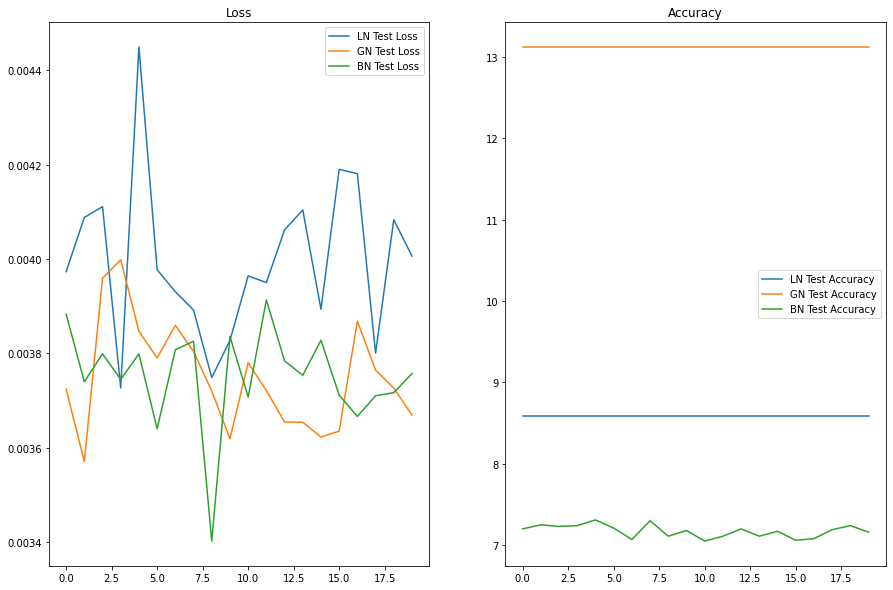

In [18]:
from torch.optim.lr_scheduler import StepLR
# list_mode =['BN']
# list_mode = ['BN','LN']
list_mode = ['LN','GN','BN']
models=[None]*len(list_mode)
# EPOCHS = 2
EPOCHS = 20

fig, axs = plt.subplots(1,2,figsize=(15,10))

for idx,mode in enumerate(list_mode):
  models[idx]=Network(mode=mode).to(device)
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
  # scheduler = StepLR(optimizer, step_size=7, gamma=0.1)
  
  if mode == 'BN':
    regularization='L1'
  else:
    regularization=None
  
  train_losses = [] # to capture train losses over training epochs
  train_accuracy = [] # to capture train accuracy over training epochs
  test_losses = [] # to capture test losses 
  test_accuracy = [] # to capture test accuracy 
  # summary(models[idx], input_size=(1, 28, 28))

  print(f'------Normalization = {mode} , Regularization = {regularization}------')
  for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(models[idx], device, train_loader, optimizer, epoch, regularization=regularization)
    test(models[idx], device, test_loader)
  # for idx,mode in enumerate(list_mode):
  # axs[0].plot(train_losses,label = str(mode)+ " Train Loss")
  # axs[0].plot(test_losses,label = str(mode)+' Test loss')
  # axs[0].set_title("Loss")
  # axs[0].legend()
  # axs[1].plot(train_accuracy,label = str(mode)+ " Train Accuracy")
  # axs[1].plot(test_accuracy,label = str(mode)+ ' Test Accuracy')
  # axs[1].set_title("Accuracy")
  # axs[1].legend()
  ######################
  # axs[0].plot(train_losses,label = str(mode)+ " Train Loss")
  axs[0].plot(test_losses,label = str(mode)+ " Test Loss")
  axs[0].set_title("Loss")
  axs[0].legend()
  # axs[1].plot(train_accuracy,label = str(mode)+ " Train Accuracy")
  axs[1].plot(test_accuracy, label = str(mode)+ ' Test Accuracy')
  axs[1].set_title("Accuracy")
  axs[1].legend()
  ######################


### Plotting Misclassified images

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


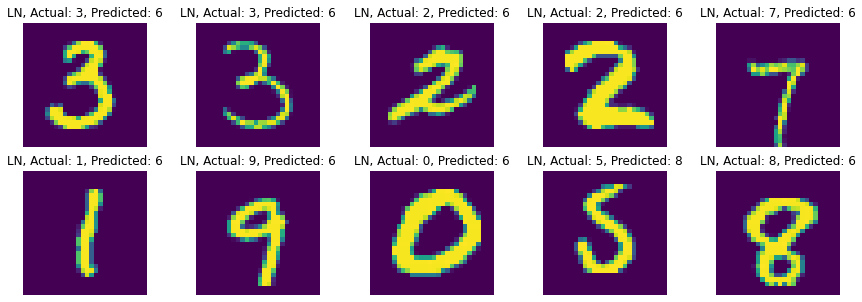

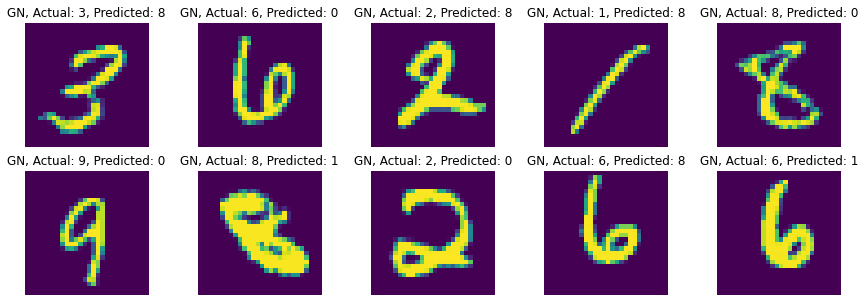

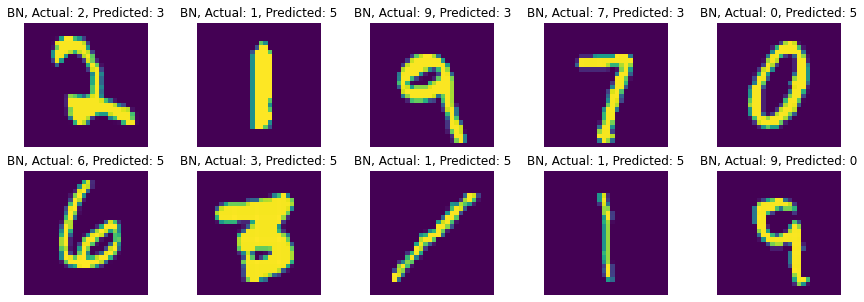

In [19]:
# Plotting misclassified Images

for idx,mode in enumerate(list_mode):
  # print(models[idx])
  incorrect_image_list =[]
  predicted_label_list =[]
  correct_label_list = []
  # incorrect = 0
  for i,(images,labels) in enumerate(test_loader):
    images, labels = images.to(device),labels.to(device)#sending data to CPU or GPU as per device
    outputs = models[idx](images) # forward pass, result captured in outputs (plural as there are many images in a batch)
    # preds = outputs.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    # incorrect += preds.neq(labels.view_as(preds))
    # print(incorrect)
    # break
    preds = outputs.argmax(dim=1, keepdim=True).squeeze(1)         
    idxs_mask = (preds !=  labels).view(-1)
    img_nm = images[idxs_mask].cpu().numpy()
    img_nm = img_nm.reshape(img_nm.shape[0], 28, 28)
    if img_nm.shape[0] > 0:
        img_list = [img_nm[i] for i in range(img_nm.shape[0])]
        incorrect_image_list.extend(img_list)
        predicted_label_list.extend(preds[idxs_mask].cpu().numpy())
        correct_label_list.extend(labels[idxs_mask].cpu().numpy())
  plt.figure(figsize=(15,5))
  i= 0
  # Display the list of 10 misclassified images
  for index, image in enumerate(incorrect_image_list) :
      ax = plt.subplot(2, 5, i+1)
      ax.set_title(str(mode) + ", Actual: " + str(correct_label_list[index]) + ", Predicted: " + str(predicted_label_list[index]))
      ax.axis('off')
      plt.imshow(image)
      i +=1
      if i==10:
          break
 
